In [1]:
import pandas as pd
# https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data
data = pd.read_csv('Store_sales_train.csv')
data

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [2]:
# modelling poultry sales
#df = data[(data['store_nbr'] == 2) & (data['family'] == 'BEVERAGES') & (data['sales'] > 0) ] 
df = data[(data['store_nbr'] == 2) & (data['family'] == 'POULTRY') & (data['sales'] > 0) ] 
df = df.set_index('date')
train_data = df['sales']
#train_data2 = train_data[:-100]
type(train_data.index)
print(len(train_data))

1679


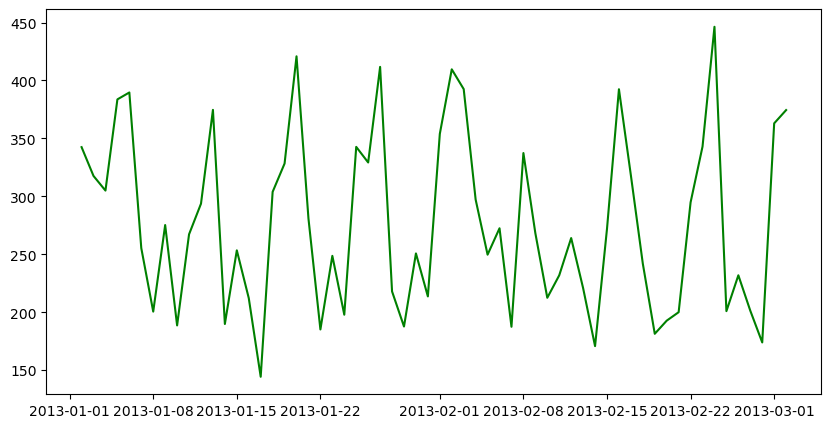

In [4]:
#checking seasonality in the data using plots
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10,5))
data_to_plot = train_data
data_to_plot.index = pd.DatetimeIndex(data_to_plot.index).to_period('d')
data2 = data_to_plot.to_timestamp(freq='d')

plt.plot(data2[:60], label = 'actual data', color="green" )

In [4]:
train_data

date
2013-01-02    342.50598
2013-01-03    317.65200
2013-01-04    305.01900
2013-01-05    383.70000
2013-01-06    389.66900
                ...    
2017-08-11    533.77400
2017-08-12    359.52200
2017-08-13    470.48700
2017-08-14    461.51102
2017-08-15    365.42400
Freq: D, Name: sales, Length: 1679, dtype: float64

In [5]:
train_data=pd.DataFrame(train_data)
train_data.index=train_data.index.to_timestamp(freq='d')

# split into train and validation data
y_train = train_data.loc[train_data.index <= '2017-03-31']
y_valid = train_data.loc[train_data.index >'2017-03-31']
len(y_train)

1542

In [6]:
# !pip install tbats
from tbats import  TBATS

# box-cox transformation:a statistical technique that transforms your target variable
# so that your data closely resembles a normal distribution. This helps making the residuals of the model as normal as possible
# and thus leads to better forecasting performance

# n_jobs: How many jobs to run in parallel when fitting TBATS model.

# monthly and weekly seasonalities
estimator= TBATS(seasonal_periods=[ 10, 7], n_jobs=5)# with box_cox transformation 
estimator2 = TBATS(seasonal_periods=[ 10, 7], use_box_cox=False, n_jobs=5)# box_cox transformation is disabled

In [7]:
# be patient!, this will take a while...
fitted_model = estimator.fit(y_train)
fitted_model2 = estimator2.fit(y_train)

In [8]:
# Summarize fitted model
print(fitted_model.summary())

Use Box-Cox: True
Use trend: False
Use damped trend: False
Seasonal periods: []
Seasonal harmonics []
ARMA errors (p, q): (4, 5)
Box-Cox Lambda 0.446918
Smoothing (Alpha): 0.087874
Seasonal Parameters (Gamma): []
AR coefficients [-0.57317168  0.20615199 -0.56273176 -0.98073111]
MA coefficients [ 0.82935373 -0.01251321  0.37162621  0.7922992   0.14203063]
Seed vector [25.68610977  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]

AIC 24710.585777


In [9]:
# Forecast len(y_valid) steps ahead and compare with real temporal data
# horizon = len(y_valid)
h =len(y_valid)
# forecasts with box-cox
y_forecasted = fitted_model.forecast(steps=h)
# forecasts without box-cox
y_forecasted2 = fitted_model2.forecast(steps=h)

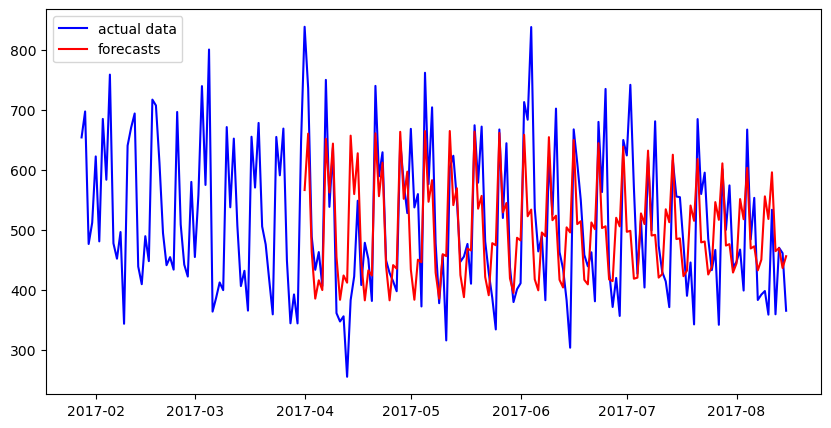

In [10]:
# plotting true against forecasts using the first model.
df_forecast=pd.DataFrame(data=y_forecasted, index=y_valid.index)


fig, ax = plt.subplots(figsize = (10,5))

plt.plot(train_data[-200:], label = 'actual data', color="blue" )
plt.plot(df_forecast, label= 'forecasts', color = 'red')
plt.legend(loc="upper left")
plt.show()

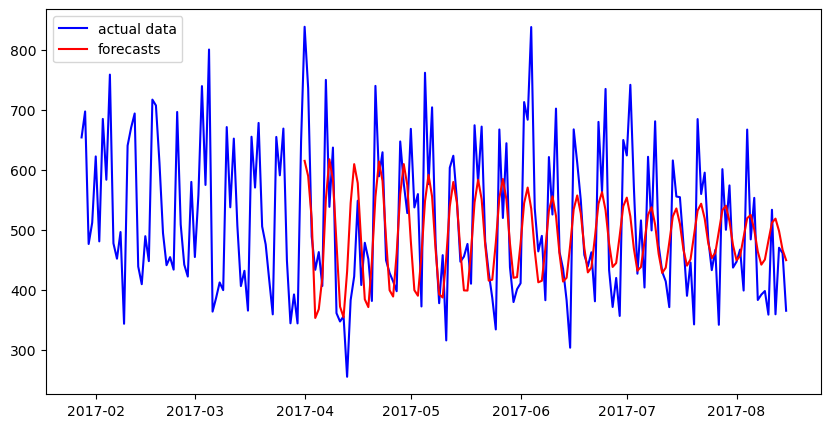

In [11]:
# plotting true against forecasts using the second model.
df_forecast2=pd.DataFrame(data= y_forecasted2, index=y_valid.index)

fig, ax = plt.subplots(figsize = (10,5))

plt.plot(train_data[-200:], label = 'actual data', color="blue" )
plt.plot(df_forecast2, label= 'forecasts', color = 'red')
plt.legend(loc="upper left")
plt.show()

In [15]:
# TBATS forecasting model evaluation: comparison
from sklearn.metrics import mean_absolute_percentage_error
print('mean absolute percentage error on test data using box-cox transformer is:', mean_absolute_percentage_error(y_forecasted, y_valid))
print('mean absolute percentage error on test data without using box-cox transformer is:', mean_absolute_percentage_error(y_forecasted2, y_valid))

mean absolute percentage error on test data using box-cox transformer is: 0.14849676445764104
mean absolute percentage error on test data without using box-cox transformer is: 0.16013166388643238
